# Building LRG Templates

The goal of this notebook is to use observations of a large number of luminous red galaxies (LRGs) with DECaLS/DR3 *grzW1W2* photometry and ancillary spectroscopic redshifts to generate a set of spectroscopic templates suitable for spectroscopic simulations, targeting investigations, and other DESI-related projects.

The parent sample consists of 2,511,248 LRGs selected from the official DECaLS/DR3.1 target catalog `targets-dr3.1-0.14.0.fits` using the selection criterion
```python
DESI_TARGET & desi_mask.LRG != 0
```

Subsequently, Rongpu Zhou (Pittsburgh) assembled spectroscopic redshifts for the sample from SDSS/Main, SDSS/BOSS, AGES, DEEP2, and VIPERS, supplemented with COSMOS medium-band photometric redshifts, yielding precise redshifts for 62,177 objects (2.4% of the parent sample).  Using these data, Zhou used a random forest technique (described elsewhere) to compute photometric redshifts for the complete sample, producing the catalog `dr3.1-0.14.0-lrg-rf-photoz-0.2.fits`, which we use as input into the generation of the spectral templates.

Specifically, we adopt the following procedure:
  1.  We focus exclusively on the subset of LRGs with spectroscopic redshifts since we find that the training sample is fairly representative of the full sample in the four-dimensional space of *g-r*, *r-z*, *z*-band magnitude, and redshift.  (Future versions of these templates may utilize the random forest photometric redshifts.)
  2. We 

Previously, the LRG templates were simple stellar populations (SSPs) spanning a range of age and stellar metallicity but not explicitly tied to survey data.  Here, we improve upon these templates in two ways.  First, 

John Moustakas
Siena College
2017 September 21

In [9]:
import numpy as np
import matplotlib.pyplot as plt

from astropy.table import Table

In [10]:
%matplotlib inline

In [7]:
cat = Table.read('legacysurvey_lrg_ckc14z_kroupa01_charlot_sfhgrid01.fits.gz')
cat[:3]

ISEDFIT_ID,RA,DEC,Z,MAGGIES [5],IVARMAGGIES [5],BESTMAGGIES [5],CHUNKINDX,MODELINDX,DELAYED,BURSTTYPE,CHI2,TOTALMASS,TOTALMASS_ERR,MSTAR,AGE,SFRAGE,TAU,ZMETAL,AV,MU,OIIIHB,NLYC,SFR,SFR100,B100,B1000,EWOII,EWOIIIHB,EWNIIHA,NBURST,TRUNCTAU,TBURST,DTBURST,FBURST,MSTAR_50,AGE_50,SFRAGE_50,TAU_50,ZMETAL_50,AV_50,MU_50,OIIIHB_50,SFR_50,SFR100_50,B100_50,B1000_50,EWOII_50,EWOIIIHB_50,EWNIIHA_50,MSTAR_AVG,AGE_AVG,SFRAGE_AVG,TAU_AVG,ZMETAL_AVG,AV_AVG,MU_AVG,OIIIHB_AVG,SFR_AVG,SFR100_AVG,B100_AVG,B1000_AVG,EWOII_AVG,EWOIIIHB_AVG,EWNIIHA_AVG,MSTAR_ERR,AGE_ERR,SFRAGE_ERR,TAU_ERR,ZMETAL_ERR,AV_ERR,MU_ERR,OIIIHB_ERR,SFR_ERR,SFR100_ERR,B100_ERR,B1000_ERR,EWOII_ERR,EWOIIIHB_ERR,EWNIIHA_ERR
int32,float64,float64,float32,float32,float32,float32,int16,int16,int32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
0,7.10186257679,-3.84164260827,0.493305,1.7658e-09 .. 2.19342e-08,2.10202e+20 .. 1.63934e+17,1.95907e-09 .. 2.72933e-08,0,3005,1,1,3.4034,3.79652e+11,2.49584e+09,11.3572,8.43379,8.25055,0.0916157,0.00775165,0.208418,0.506265,-1.0,52.1077,-3.42061,-3.42061,-15.0,-15.0,-1.0,-1.0,-1.0,0,-1.0,-1.0,-1.0,-1.0,11.3304,7.99743,6.93651,0.124043,0.00873057,0.314216,0.357754,-1.0,-3.42019,-3.42019,-15.0,-13.4455,-1.0,-1.0,-1.0,11.319,7.49219,6.91142,0.290627,0.0089476,0.36689,0.349315,-1.0,-2.85242,-3.17479,-10.7666,-10.4481,-1.0,-1.0,-1.0,0.059242,0.856211,0.86443,0.199598,0.00219014,0.323897,0.0918706,0.0,0.735066,0.493306,2.93409,3.00125,0.0,0.0,0.0
1,7.23270630501,-3.73900323383,0.596124,1.21947e-09 .. 3.73271e-08,3.41204e+20 .. 1.61952e+17,1.38542e-09 .. 4.38815e-08,0,1746,1,1,4.81293,7.38799e+11,3.82096e+09,11.6527,6.85219,6.73449,0.0588457,0.0144248,0.174484,0.521158,-1.0,52.1897,-3.13147,-3.13147,-15.0,-15.0,-1.0,-1.0,-1.0,0,-1.0,-1.0,-1.0,-1.0,11.6497,6.91977,6.72835,0.100916,0.0144248,0.406731,0.254227,-1.0,-3.12706,-3.13482,-15.0,-15.0,-1.0,-1.0,-1.0,11.6523,7.06551,6.69376,0.185881,0.0141004,0.372666,0.320061,-1.0,-2.96507,-3.12227,-12.9086,-12.6098,-1.0,-1.0,-1.0,0.0230553,0.353224,0.365486,0.113796,0.00143068,0.188852,0.0777556,0.0,0.249084,0.024488,2.43004,2.54153,0.0,0.0,0.0
2,7.25075960888,-3.69038082861,0.417064,4.01967e-09 .. 6.68506e-08,2.36941e+20 .. 1.39383e+17,4.22141e-09 .. 6.91748e-08,0,1845,1,1,6.53943,6.02214e+11,1.78635e+09,11.5653,6.58946,6.50841,0.0405254,0.0174149,0.206621,0.421606,-1.0,52.0855,-3.22025,-3.22025,-15.0,-15.0,-1.0,-1.0,-1.0,0,-1.0,-1.0,-1.0,-1.0,11.5563,7.2391,6.6888,0.24461,0.0164273,0.243011,0.256191,-1.0,-3.21876,-3.21876,-11.2897,-10.2249,-1.0,-1.0,-1.0,11.5557,7.30037,6.7142,0.293187,0.0166676,0.341988,0.296434,-1.0,-2.72534,-2.99061,-10.4868,-9.94606,-1.0,-1.0,-1.0,0.0325592,0.668907,0.633558,0.180791,0.00261316,0.233652,0.0862318,0.0,0.667253,0.419559,2.87642,2.94797,0.0,0.0,0.0


In [8]:
kcorr = Table.read('legacysurvey_lrg_ckc14z_kroupa01_charlot_sfhgrid01_kcorr.z0.0.fits.gz')
kcorr[:3]

ISEDFIT_ID,Z,MAGGIES [5],IVARMAGGIES [5],CHI2,FLAM_1500,CFLUX_3727,KCORRECT [3],ABSMAG [3],IVARABSMAG [3],SYNTH_ABSMAG [3],ABSMAG_FILTERLIST [3]
int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,str11
0,0.493305,1.7658e-09 .. 2.19342e-08,2.10202e+20 .. 1.63934e+17,3.4034,8.62409e-19,1.93438e-17,0.0124708 .. 0.0714089,-22.1503 .. -23.2998,8778.52 .. 9104.59,-22.1392 .. -23.3014,decam_g.par .. decam_z.par
1,0.596124,1.21947e-09 .. 3.73271e-08,3.41204e+20 .. 1.61952e+17,4.81293,6.44898e-19,1.93495e-17,0.415429 .. 0.191121,-22.7973 .. -24.0572,9283.86 .. 18576.3,-22.7938 .. -24.0487,decam_g.par .. decam_z.par
2,0.417064,4.01967e-09 .. 6.68506e-08,2.36941e+20 .. 1.39383e+17,6.53943,1.18799e-18,3.28199e-17,-0.168682 .. 0.111303,-22.5102 .. -23.7975,51005.0 .. 36417.2,-22.5025 .. -23.7953,decam_g.par .. decam_z.par


In [11]:
Mg, Mr, Mz = kcorr['ABSMAG'][:, 0], kcorr['ABSMAG'][:, 1], kcorr['ABSMAG'][:, 2]

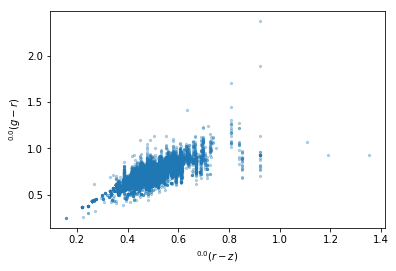

In [17]:
fig, ax = plt.subplots()
ax.scatter(Mr-Mz, Mg-Mr, alpha=0.3, s=5)
ax.set_xlabel(r'$^{0.0}(r - z)$')
ax.set_ylabel(r'$^{0.0}(g - r)$')

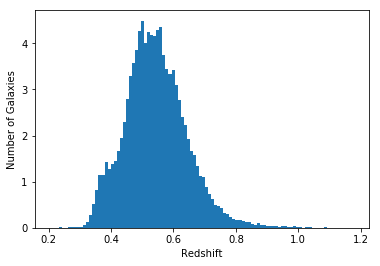

In [22]:
fig, ax = plt.subplots()
_ = ax.hist(kcorr['Z'], bins=100, normed=True)
ax.set_xlabel('Redshift')
ax.set_ylabel('Number of Galaxies')